# Translation with a Sequence to Sequence Network and Attention

英語から日本語への翻訳を行えるネットワークを構築する。
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

コーパスは以下のものを使用する。
https://github.com/odashi/small_parallel_enja

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
! head -n 5 data/small_parallel_enja/train.en

i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
emi looks happy .
please bear this fact in mind .


In [9]:
! head -n 5 data/small_parallel_enja/train.ja

誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
エミ は 幸せ そう に 見え ま す 。
この 事実 を 心 に 留め て お い て 下さ い 。


In [10]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)
        
        
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines1 = open('data/small_parallel_enja/train.{}'.format(lang1), encoding='utf-8').\
        read().strip().split('\n')
    lines2 = open('data/small_parallel_enja/train.{}'.format(lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs
    pairs = [[s1, s2] for (s1, s2) in zip(lines1, lines2)]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('en', 'ja', False)
print(random.choice(pairs))

Reading lines...
Read 50000 sentence pairs
Counting words...
Counted words:
en 6636
ja 8776
['my father made me a nice lunch .', '父 が 私 に おいし い 昼食 を 作 っ て くれ た 。']


In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        #self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = F.dropout(embedded, p=self.dropout_p, training=self.training)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_weights = F.dropout(attn_wights, p=self.dropout_p, training=self.training)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = F.dropout(output, p=self.dropout_p, training=self.training)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [20]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [24]:
hidden_size = 1024
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.5).to(device)

In [26]:
encoder.parameters() + attn_decoder.parameters()

TypeError: unsupported operand type(s) for +: 'generator' and 'generator'

In [ ]:
hidden_size = 1024
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=1000)

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> be sure to switch off the television before you go to sleep .
= 必ず テレビ の スイッチ を 切 り なさ い 。
< 必ず 時 に 必ず 時 に 必ず を する べ き なさ い 。 <EOS>

> i saw her only a week ago .
= 彼女 に あ っ た の は つい 一 週間 前 の こと だ 。
< １ 週間 週間 前 に 彼女 を 見 た 。 <EOS>

> he stepped out for a moment .
= 彼 は ちょっと 席 を はず し て い ま す 。
< 彼 は ちょっと を 見 を 。 <EOS>

> i don 't know how to cook too many things .
= 料理 の レパートリー は 限 ら れ て る の 。
< 私 は 何 を 何 を 何 か い て い い 。 。 。 。 <EOS>

> why don 't you drop her a line ?
= 彼女 に 一筆 書 い て み たら どう で す か 。
< 彼女 に 電話 を する の で は か 。 <EOS>

> tom is still in hospital .
= トム は まだ 入院 し て い る 。
< トム は まだ まだ し て い る 。 <EOS>

> her story was not interesting .
= 彼女 の 話 は 面白 く な かっ た 。
< 彼女 の 話 は 面白 く な かっ た 。 <EOS>

> when will we eat dinner , mom ?
= お 母 さん 、 夕食 は 何 時 で す か 。
< いつ 、 私 たち に 食事 を し ま しょ う 。 <EOS>

> she looked at the picture .
= 彼女 は 絵 を 見 ま し た 。
< 彼女 は 絵 を 見 を 見 見 。 。 <EOS>

> she set about writing the essay .
= 彼女 は 随筆 を 書 き 始め た 。
< 彼女 は その の に を 。 た <EOS>



input = i 'm very happy to know you .
output = お は て うれし て うれし い と 思 い ま す 。 <EOS>


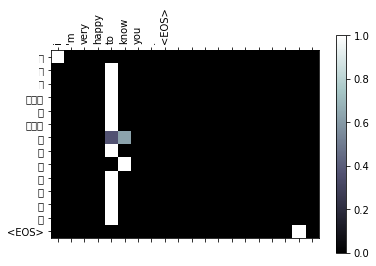

input = i didn 't know he had decided to leave .
output = 私 は 彼 は 出発 し よ と し た い 。 <EOS>


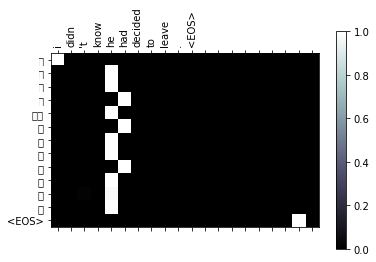

input = she was beautiful in her time .
output = 彼女 は は で 美し く な っ た 。 <EOS>


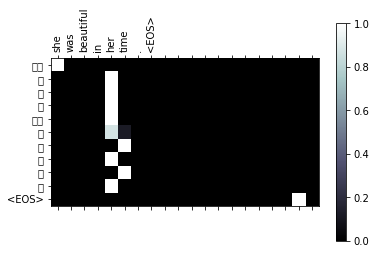

input = her illness prevented her from attending the party .
output = 彼女 の 病気 の ため に パーティー に た た 。 た <EOS>


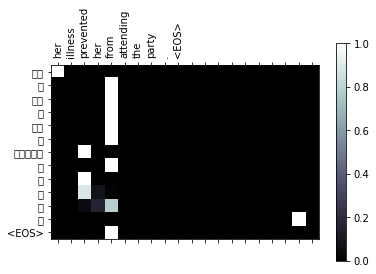

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i 'm very happy to know you .")
evaluateAndShowAttention("i didn 't know he had decided to leave .")
evaluateAndShowAttention("she was beautiful in her time .")
evaluateAndShowAttention("her illness prevented her from attending the party .")